# Logistic Regression
It's a supervised ML technique used for classification.

<b>Sentiment Analysis :</b> 
It is an NLP technique that allows us to classify a tweet as either Positive, Neutral or Negative.
Here, we train our model on tweet_dataset that was also used for BERT algorithm
So, here we will extract frequencies of every word making a frequency dictionary

## Import

In [1]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import nltk
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Load Training Dataset

In [2]:
df= pd.read_csv('/content/tweet_dataset.csv')
df.head()

,textID,sentiment,author,text,old_text,aux_id,new_sentiment,selected_text
0,1956967341,empty,xoshayzers,i know i was listenin to bad habit earlier a...,@tiffanylue i know i was listenin to bad habi...,p1000000000,NaN,NaN
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,Layin n bed with a headache ughhhh...waitin o...,c811396dc2,negative,headache
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...,9063631ab1,negative,gloomy
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants to hang out with friends SOON!,2a815f151d,positive,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,We want to trade with someone who has Houston...,@dannycastillo We want to trade with someone w...,82565a56d3,neutral,We want to trade with someone who has Houston ...


In [3]:
train= pd.DataFrame()
train['text']= df['text']
train['Sentiment']=df['new_sentiment']
train=train.dropna()
train['Sentiment'] = train['Sentiment'].replace(['negative','neutral','positive'],[0,1,2])

# split the data according to their sentiment
all_positive_tweets = pd.DataFrame()
all_negative_tweets = pd.DataFrame()
all_negative_tweets = train.loc[train['Sentiment'] == 0]
all_negative_tweets = all_negative_tweets.drop(['Sentiment'], axis = 1)
all_positive_tweets = train.loc[train['Sentiment'] == 2]
all_positive_tweets = all_positive_tweets.drop(['Sentiment'], axis = 1)


# split the data into two pieces, one for training and one for testing (validation set) 
test_pos = all_positive_tweets[7500:].to_numpy()
train_pos = all_positive_tweets[:7500].to_numpy()
test_neg = all_negative_tweets[7500:].to_numpy()
train_neg = all_negative_tweets[:7500].to_numpy()
train_x =np.concatenate((train_pos,train_neg)) 
test_x = np.concatenate((test_pos,test_neg))


# combine positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)
train_x=train_x.reshape(len(train_x),).tolist()
test_x=test_x.reshape(len(test_x),).tolist()

In [16]:
pd.read_csv('/content/vaccination_all_tweets.csv')

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100340,1400936671994990593,Journalist Siraj Noorani,mumbai,"Independent Journalist, & foodblogger Check Ou...",2010-08-22 10:03:30,882,2674,3912,False,2021-06-04 22:05:05,The Brihan #Mumbai Municipal Corporation (@myb...,['Mumbai'],Twitter for Android,1,1,False
100341,1400928767602798592,DTT-NET English,Prishtina and Brussels,"News agency specialized on Western Balkans, EU...",2014-08-16 16:35:07,423,221,2,False,2021-06-04 21:33:40,#Serbian and #Russian Presidents mark start of...,"['Serbian', 'Russian', 'SputnikV', 'COVID19', ...",Twitter Web App,0,0,False
100342,1400924723769450497,Kishore Mordani,Moscow,"Born and raised in Mumbai, living in Moscow, e...",2011-11-06 18:42:13,128,311,506,False,2021-06-04 21:17:36,Got the #sputnikV today and with that the love...,"['sputnikV', 'eskimo', 'chocobar']",Twitter for iPhone,0,0,False
100343,1400915490810249219,Sputnik V,"Moscow, Russia",Sputnik V is the world’s first registered COVI...,2020-08-11 09:12:38,563066,154,1964,True,2021-06-04 20:40:55,#WATCH The historic moment of #SputnikV produc...,"['WATCH', 'SputnikV']",TweetDeck,177,675,False


In [17]:
all_tweet = pd.read_csv('/content/vaccination_all_tweets.csv')
JandJ = pd.read_csv('/content/scraped_tweets.csv')
all_tweet= all_tweet.drop(['user_name','user_description','user_created','user_followers','user_friends','user_favourites','source','is_retweet', 'user_verified', 'retweets', 'favorites'],axis=1)
frames = [all_tweet, JandJ]
result = pd.concat(frames, ignore_index=True)
all_tweet = result 
all_tweet

,id,user_location,date,text,hashtags
0,1340539111971516416,"La Crescenta-Montrose, CA",2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech']
1,1338158543359250433,"San Francisco, CA",2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN
2,1337858199140118533,Your Bed,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf..."
3,1337855739918835717,"Vancouver, BC - Canada",2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN
4,1337854064604966912,NaN,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']"
...,...,...,...,...,...
108553,8209,NaN,12/12/2020 1:49,@FergalBowers @rtenews COVID 19 VACCINES ARE N...,NaN
108554,8210,NaN,12/12/2020 7:35,@drivetimerte @RTERadio1 @SarahAMcInerney @rte...,NaN
108555,8211,NaN,12/12/2020 7:41,@BBCBreaking @MichealMartinTD @CMOIreland @rte...,NaN
108556,8212,NaN,12/12/2020 7:45,@PresidentIRL @merrionstreet @HSELive @merrion...,NaN


## Pre-Processing Tweet

In [18]:
#Preprocessing tweets
def process_tweet(tweet):
    #Remove old style retweet text "RT"
    tweet2 = re.sub(r'^RT[\s]','', tweet)
    
    #Remove hyperlinks
    tweet2 = re.sub(r'https?:\/\/.*[\r\n]*','', tweet2)
    
    #Remove hastags
    #Only removing the hash # sign from the word
    tweet2 = re.sub(r'#','',tweet2)
        
    # instantiate tokenizer class
    tokenizer = TweetTokenizer(preserve_case=False,    strip_handles=True, reduce_len=True)
    
    # tokenize tweets
    tweet_tokens = tokenizer.tokenize(tweet2)    
        
    #Import the english stop words list from NLTK
    stopwords_english = stopwords.words('english') 
    
    #Creating a list of words without stopwords
    tweets_clean = []
    for word in tweet_tokens:
        if word not in stopwords_english and word not in string.punctuation:
            tweets_clean.append(word)
        
    #Instantiate stemming class
    stemmer = PorterStemmer()
    
    #Creating a list of stems of words in tweet
    tweets_stem = []
    for word in tweets_clean:
        stem_word = stemmer.stem(word)
        tweets_stem.append(stem_word)
        
    return tweets_stem

### Building Frequency Dictionary

In [19]:
#Frequency generating function
def build_freqs(tweets, ys):
    yslist = np.squeeze(ys).tolist()
    
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            freqs[pair] = freqs.get(pair, 0) + 1
            
    return freqs

In [20]:
# create frequency dictionary
freqs = build_freqs(train_x, train_y)

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))

type(freqs) = <class 'dict'>
len(freqs) = 17641


## Model

### Sigmoid Function

In [21]:
def sigmoid(z): 
    '''
    Input:
        z: is the input (can be a scalar or an array)
    Output:
        h: the sigmoid of z
    '''
    # calculate the sigmoid of z
    h = 1/(1 + np.exp(-z))
    
    return h

### Cost Function & Gradient Descent

In [22]:
def gradientDescent(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector
    Hint: you might want to print the cost to make sure that it is going down.
    '''
    
    m = len(x)
  
    for i in range(0, num_iters):
        
        # get z, the dot product of x and theta
        z = np.dot(x,theta)
        
        # get the sigmoid of z
        h = sigmoid(z)
        
        # calculate the cost function
        J = (-1/m)*(np.dot(y.T,np.log(h)) + np.dot((1-y).T,np.log(1-h)))
        
        # update the weights theta
        theta = theta - (alpha/m)*np.dot(x.T, h-y)
        
    J = float(J)
    return J, theta

def extract_features(tweet, freqs):
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1 
        
    # loop through each word in the list of words
    for word in word_l:
        
        # increment the word count for the positive label 1
        x[0,1] += freqs.get((word,1),0)
        
        # increment the word count for the negative label 0
        x[0,2] += freqs.get((word,0),0)
        
    assert(x.shape == (1, 3))
    return x

In [23]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

# training labels corresponding to X
Y = train_y


In [24]:

# Apply gradient descent
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 1500)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

The cost after training is 0.67078203.
The resulting vector of weights is [-1e-08, 0.00014725, -0.00010814]


In [25]:
def predict_tweet(tweet, freqs, theta):
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''
    
    # extract the features of the tweet and store it into x
    x = extract_features(tweet, freqs)
    
    # make the prediction using x and theta
    z = np.dot(x,theta)
    y_pred = sigmoid(z)
    
    
    return y_pred
def test_logistic_regression(test_x, test_y, freqs, theta):
    """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
        
    # the list for storing predictions
    y_hat = []
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1)
        else:
            # append 0 to the list
            y_hat.append(0)
# With the above implementation, y_hat is a list, but test_y is (m,1) array
    # convert both to one-dimensional arrays in order to compare them using the '==' operator
    y_hat = np.array(y_hat)
    test_y = test_y.reshape(-1)
    accuracy = np.sum((test_y == y_hat).astype(int))/len(test_x)
    
    return accuracy

In [26]:
tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, theta)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")

Logistic regression model's accuracy = 0.7293


In [27]:
senti = []
for my_tweet in all_tweet['text']:
  process_tweet(my_tweet)
  y_hat = predict_tweet(my_tweet, freqs, theta)
  if y_hat > 0.5:
    senti.append('Positive')
  else:
    senti.append('Negative')

In [28]:
all_tweet['Sentiment'] = senti
data=all_tweet
data

,id,user_location,date,text,hashtags,Sentiment
0,1340539111971516416,"La Crescenta-Montrose, CA",2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Positive
1,1338158543359250433,"San Francisco, CA",2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Positive
2,1337858199140118533,Your Bed,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Positive
3,1337855739918835717,"Vancouver, BC - Canada",2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Negative
4,1337854064604966912,NaN,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Negative
...,...,...,...,...,...,...
108553,8209,NaN,12/12/2020 1:49,@FergalBowers @rtenews COVID 19 VACCINES ARE N...,NaN,Positive
108554,8210,NaN,12/12/2020 7:35,@drivetimerte @RTERadio1 @SarahAMcInerney @rte...,NaN,Positive
108555,8211,NaN,12/12/2020 7:41,@BBCBreaking @MichealMartinTD @CMOIreland @rte...,NaN,Positive
108556,8212,NaN,12/12/2020 7:45,@PresidentIRL @merrionstreet @HSELive @merrion...,NaN,Positive


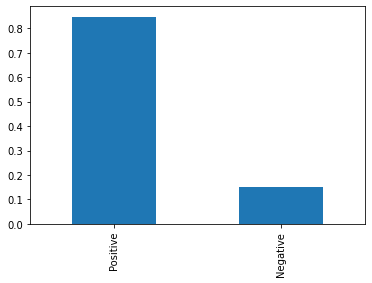

In [29]:
data['Sentiment'].value_counts(normalize=True).plot.bar()

In [30]:
data['date'] = pd.to_datetime(data['date'], errors='coerce').dt.date
data['Sentiment'] = data['Sentiment'].map({'Negative':0,'Positive':1})
vax=data

In [31]:
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik','johnson']

vax_sentiment = pd.DataFrame()
vax_sentiment['Vaccine']=all_vax
sentiments=list()

In [32]:
def time_variance(vacc) :
    if vacc=='all':
        vacc=vax
    else :   
        vacc=vax[vax['text'].str.lower().str.contains(vacc)]
        sentiments.append(vacc.Sentiment.mean())

    temp=pd.DataFrame()
    temp['date'] = sorted(vacc['date'].unique())
    senti=list()

    for date in temp['date']:
        senti.append(vacc[vacc['date']==date].Sentiment.mean())

    temp['Sentiment']=senti
    
    fg,axs=plt.subplots(figsize=(15,7))
    sns.lineplot(ax=axs,x='date',y='Sentiment', data= temp)
    axs.set_xlabel("Time",size=16)
    axs.set_ylabel("Sentiment",size=16)
    axs.set_title("Variance of Sentiment wrt Time",size=24)
    axs.grid()

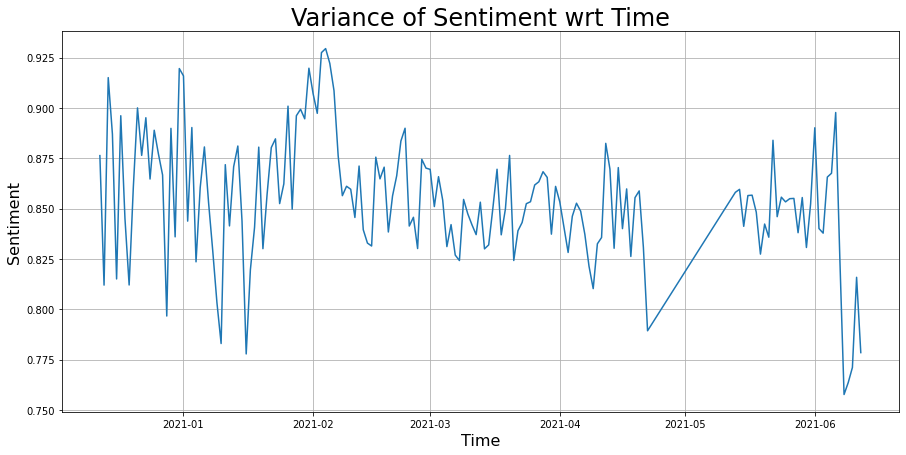

In [33]:
time_variance('all')


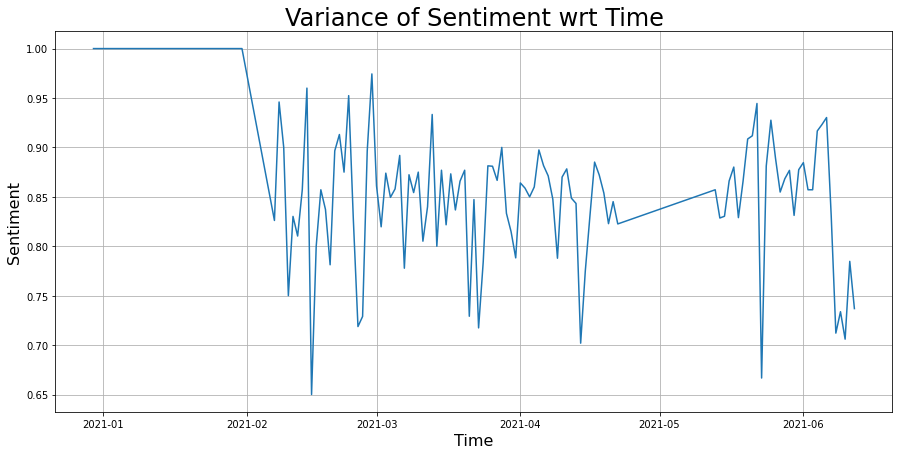

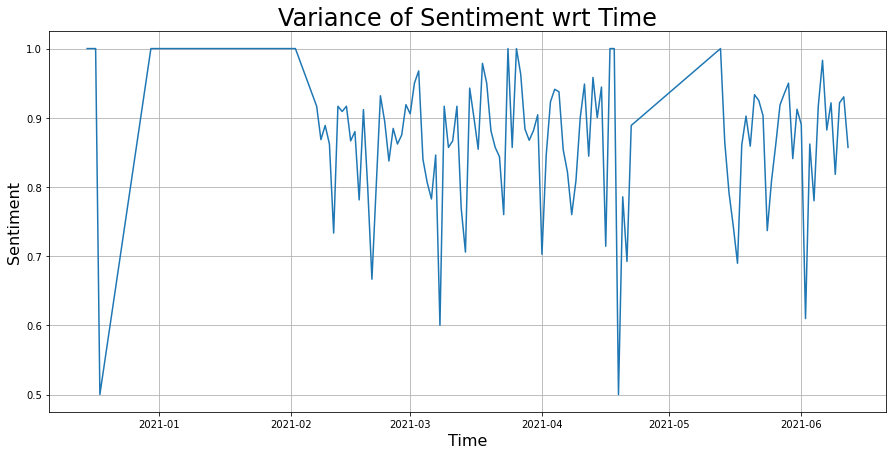

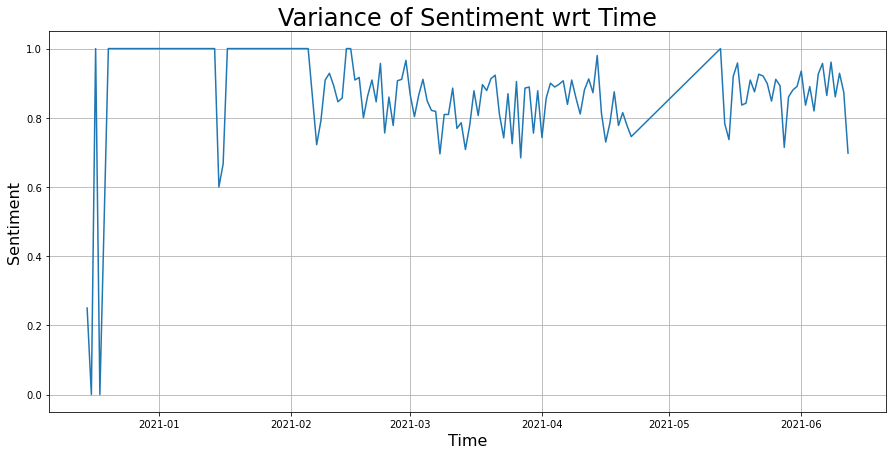

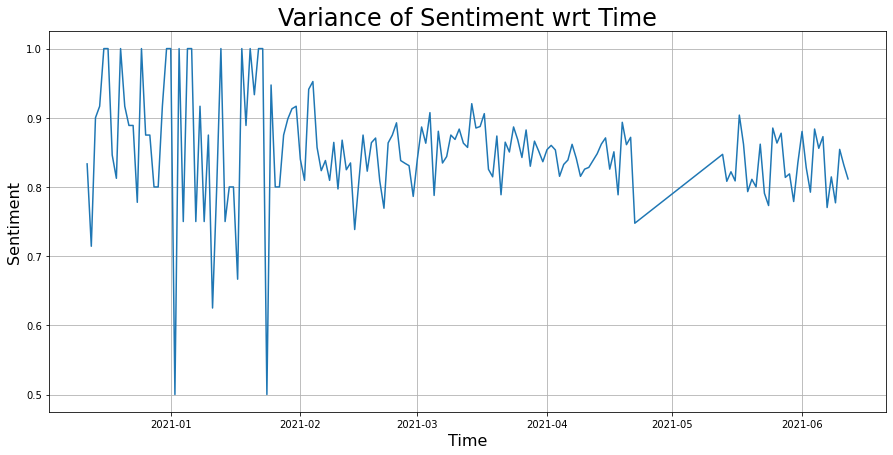

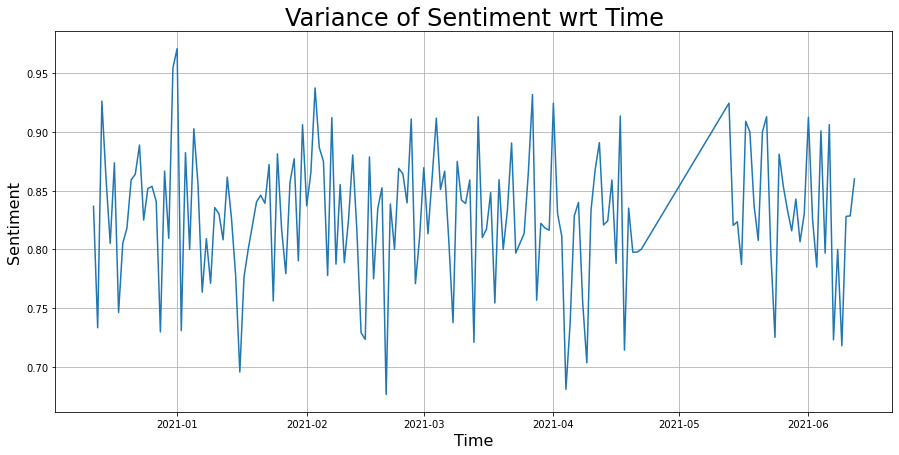

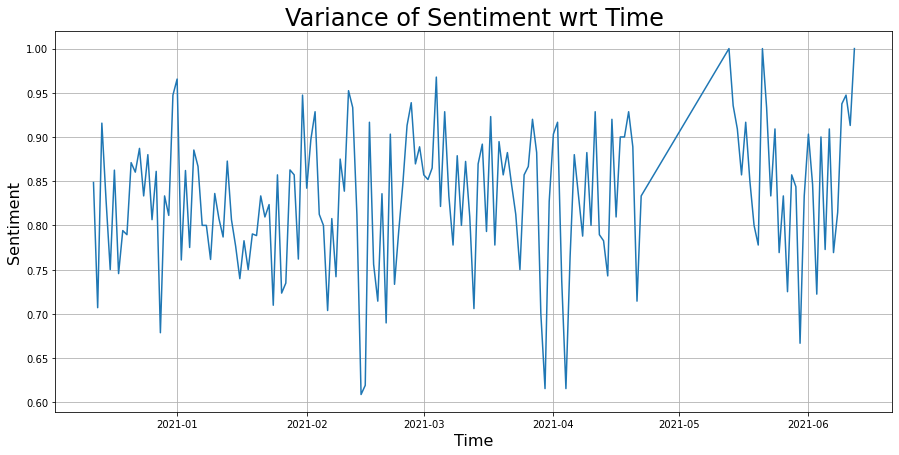

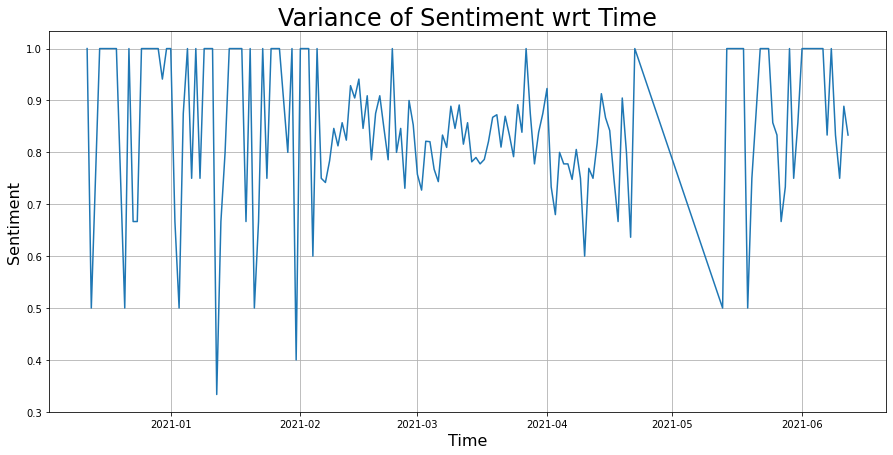

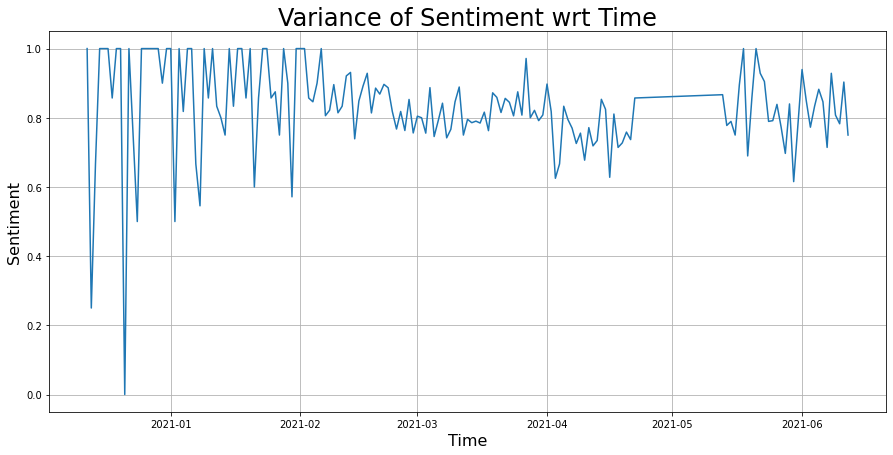

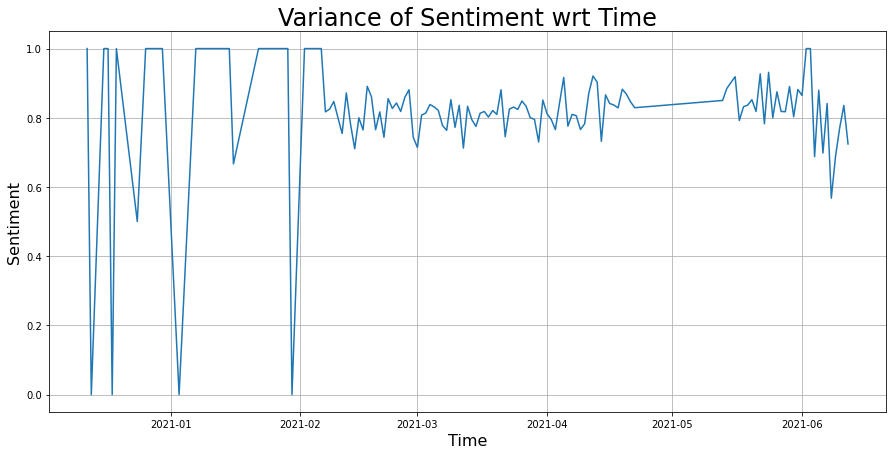

In [34]:
time_variance('covaxin')
time_variance('sinopharm')
time_variance('sinovac')
time_variance('moderna')
time_variance('pfizer')
time_variance('biontech')
time_variance('oxford')
time_variance('astrazeneca')
time_variance('sputnik')

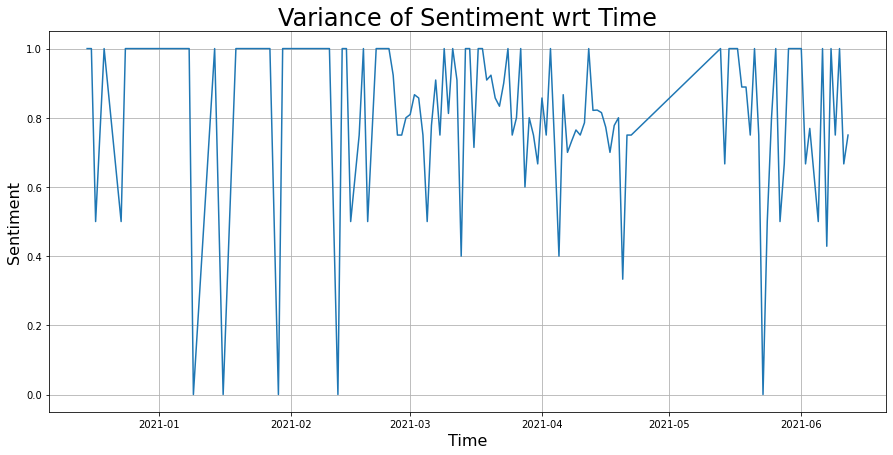

In [51]:
time_variance('johnson')

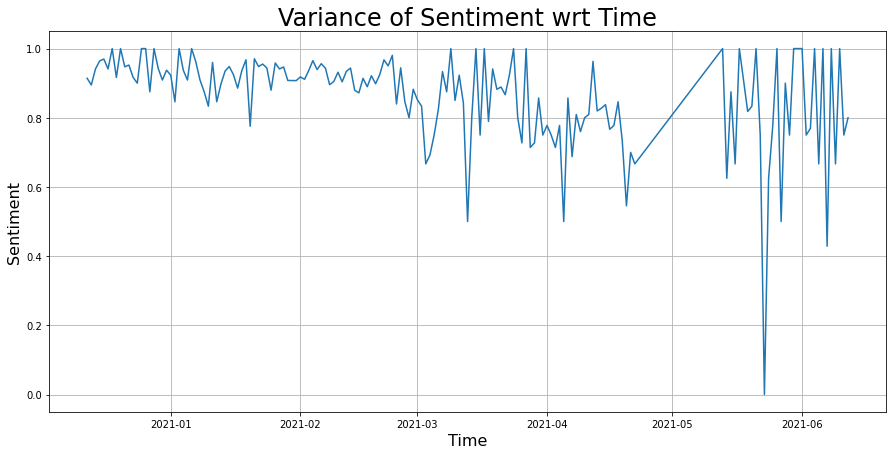

In [35]:
time_variance('johnson')

In [36]:
sentiments


[0.8313253012048193,
 0.8718437351119581,
 0.8629332289015077,
 0.8465042417150738,
 0.8279840741041684,
 0.826705519369215,
 0.824381412190706,
 0.8145479499056442,
 0.8357556918423926,
 0.8989462592202319]

Text(0.5, 1.0, 'Mean Sentiment of Vaccines')

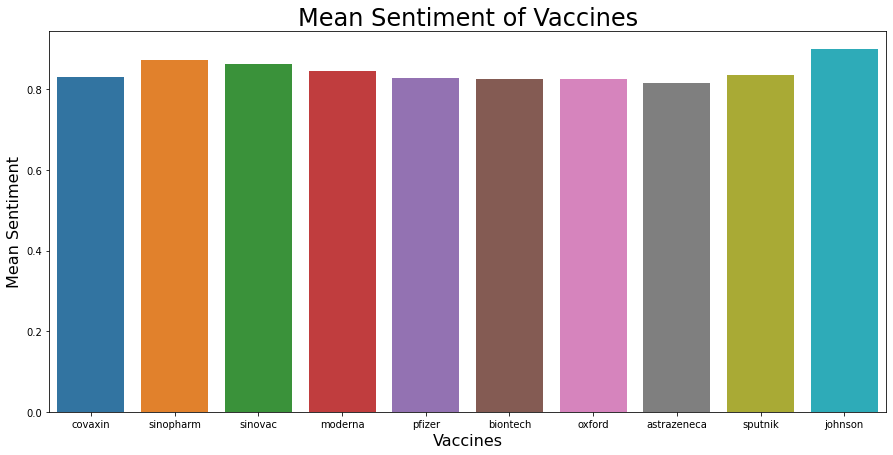

In [37]:
vax_sentiment['Sentiment']=sentiments

fg,axs=plt.subplots(figsize=(15,7))
sns.barplot(ax=axs,x='Vaccine',y='Sentiment',data=vax_sentiment)
axs.set_xlabel("Vaccines",size=16)
axs.set_ylabel("Mean Sentiment",size=16)
axs.set_title("Mean Sentiment of Vaccines",size=24)

In [64]:
def time_variance_vax_count(vacc, country, sento) :
    if vacc=='all':
        vacc=vax
    else :   
        vacc=vax[vax['text'].str.lower().str.contains(vacc)]
        vacc=vacc[vacc['user_location'].str.lower().str.contains(country)]
        sento.append(vacc.Sentiment.mean())

    temp=pd.DataFrame()
    temp['date'] = sorted(vacc['date'].unique())
    senti=list()

    for date in temp['date']:
        senti.append(vacc[vacc['date']==date].Sentiment.mean())

    temp['Sentiment']=senti
    
    fg,axs=plt.subplots(figsize=(15,7))
    sns.lineplot(ax=axs,x='date',y='Sentiment', data= temp)
    axs.set_xlabel("Time",size=16)
    axs.set_ylabel("Sentiment",size=16)
    axs.set_title("Variance of Sentiment wrt Time",size=24)
    axs.grid()

def bar_graph_country(country):
  sento=[]
  for vaccine in all_vax:
    time_variance_vax_count(vaccine, country, sento)
  print(sento)
  vax_sentiment['Sentiment']=sento
  fg,axs=plt.subplots(figsize=(15,7))
  sns.barplot(ax=axs,x='Vaccine',y='Sentiment',data=vax_sentiment)
  axs.set_xlabel("Vaccines",size=16)
  axs.set_ylabel("Mean Sentiment",size=16)
  axs.set_title("Mean Sentiment of Vaccines for {}".format(country),size=24)



In [ ]:
for country in countries:
  bar_graph_country(country)

[0.8506217535022824, 0.8857142857142857, 0.916030534351145, 0.817910447761194, 0.8027950310559007, 0.8359788359788359, 0.8961038961038961, 0.8516129032258064, 0.8858082706766918, 0.78125]


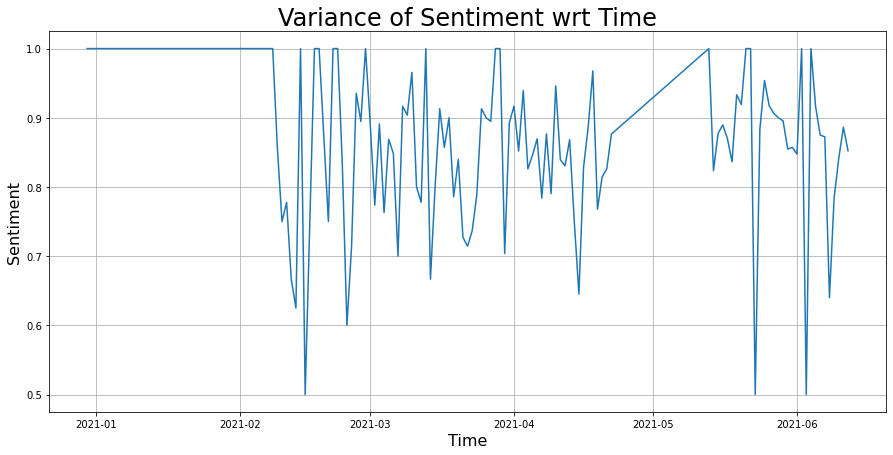

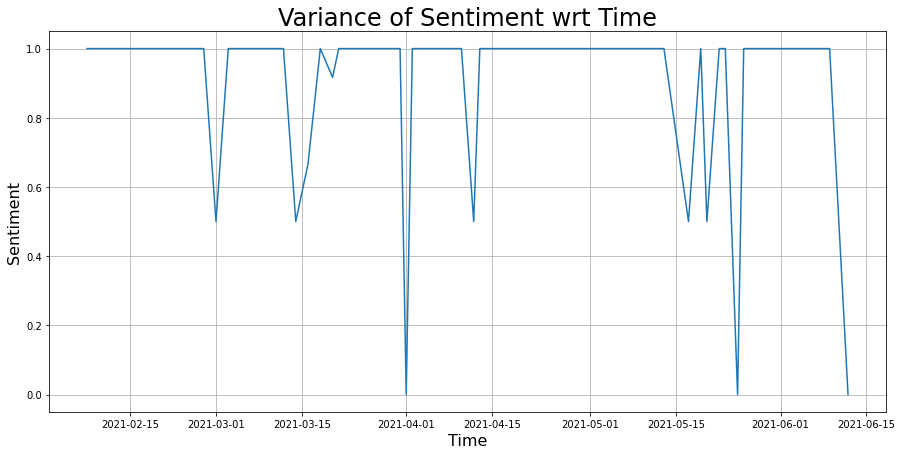

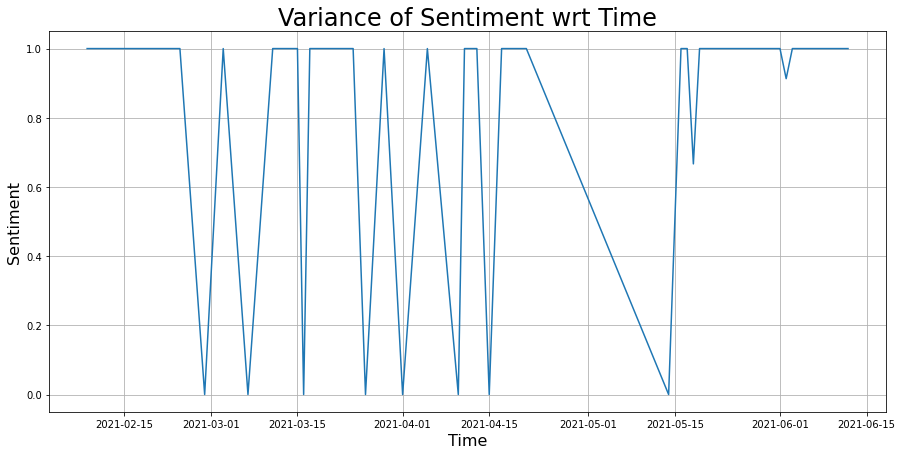

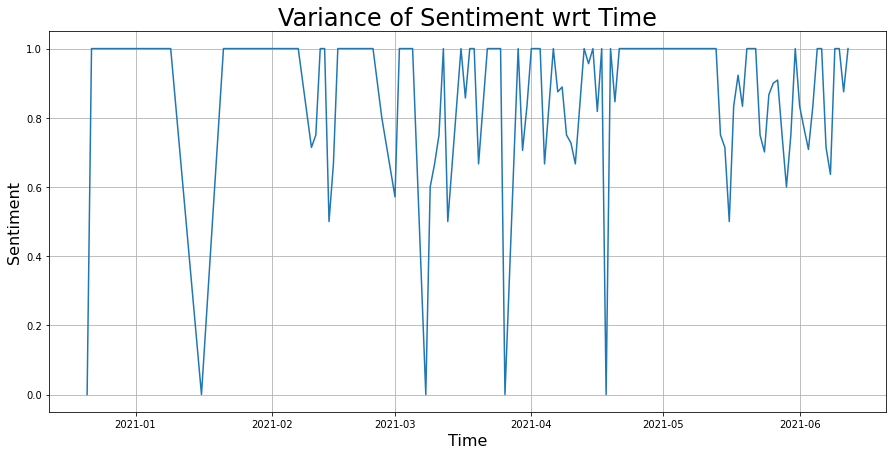

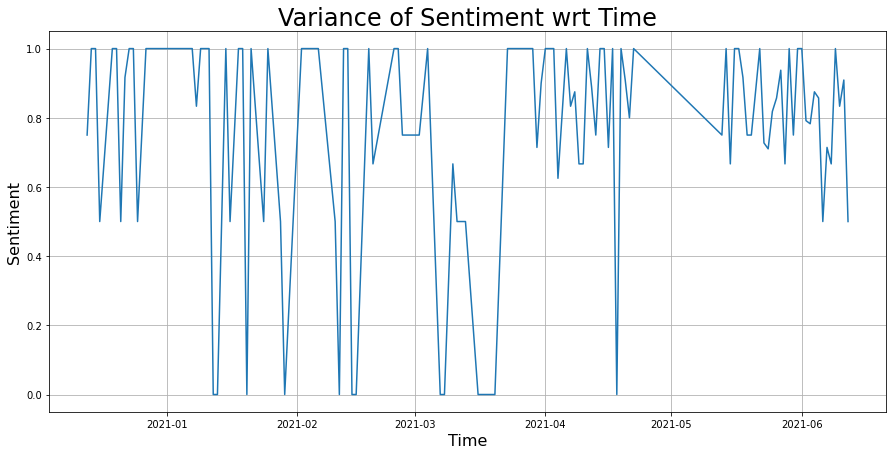

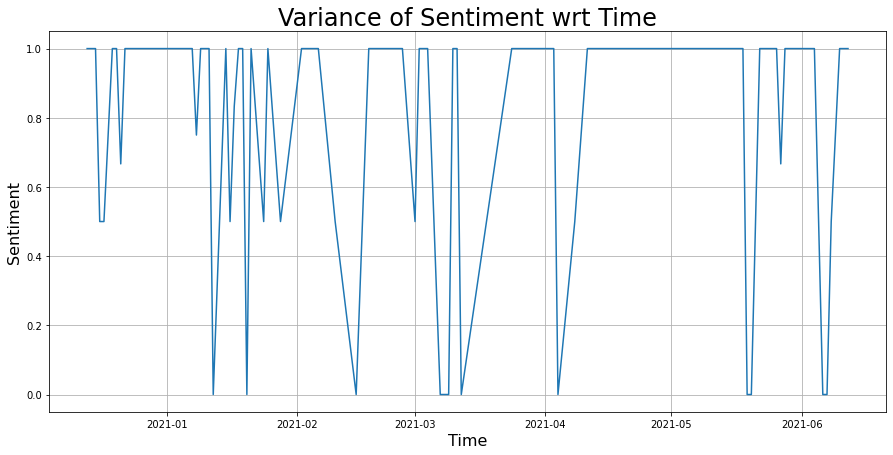

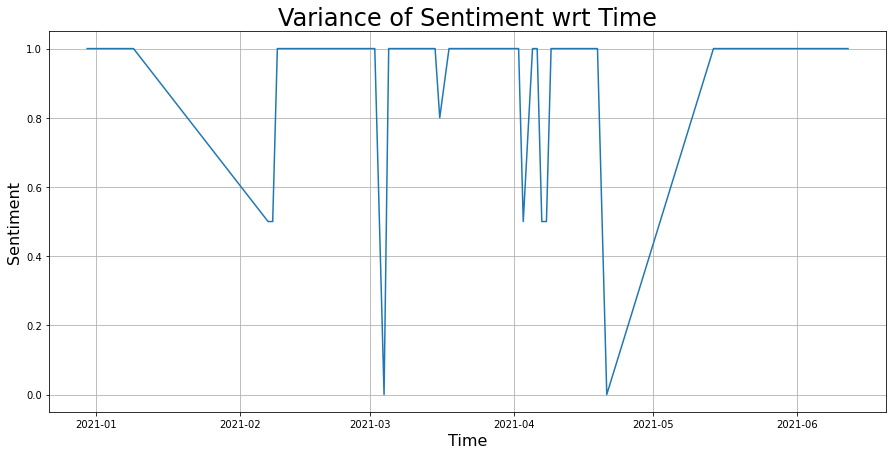

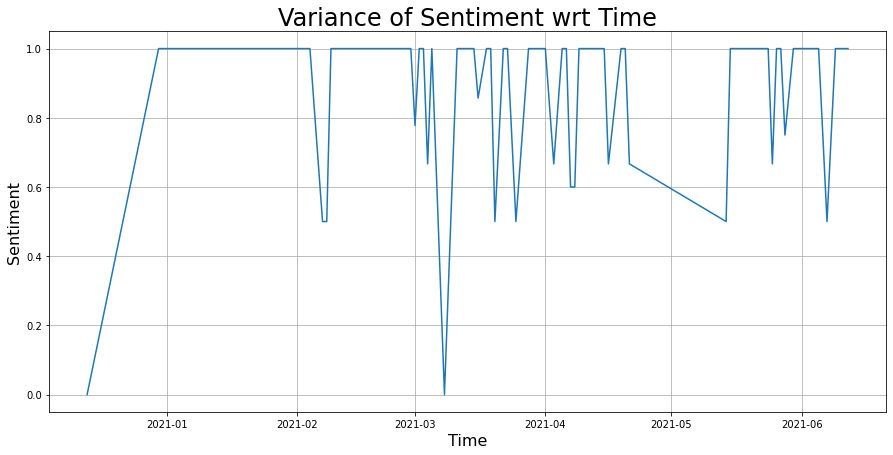

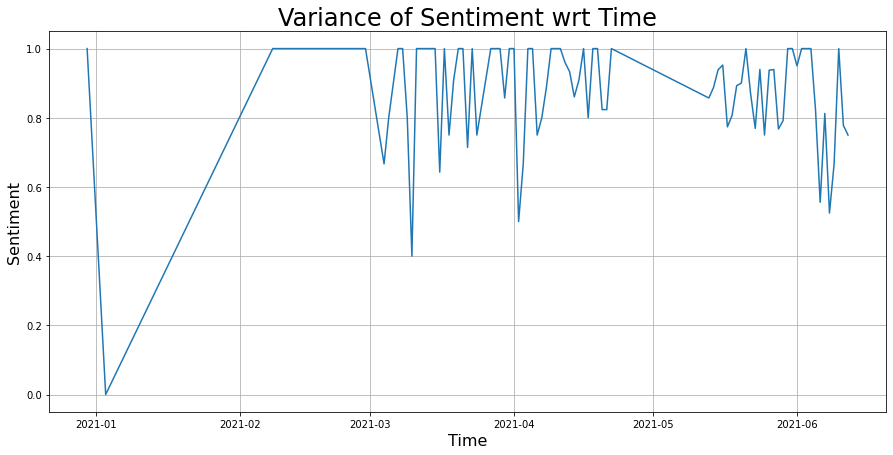

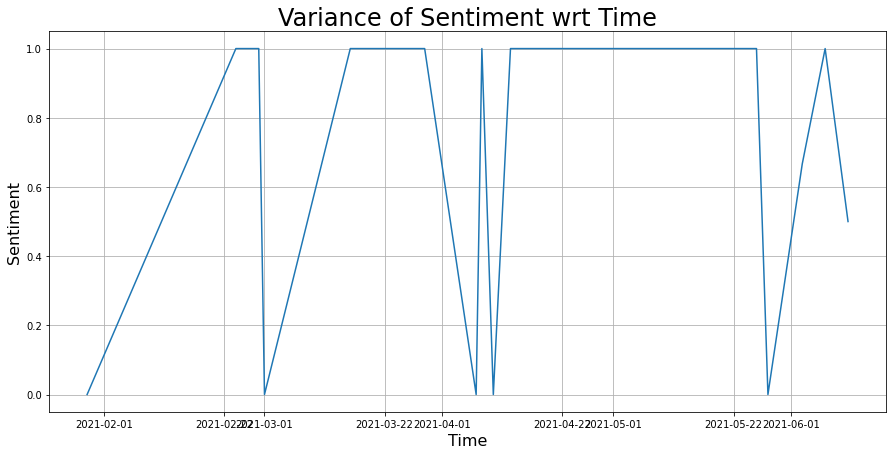

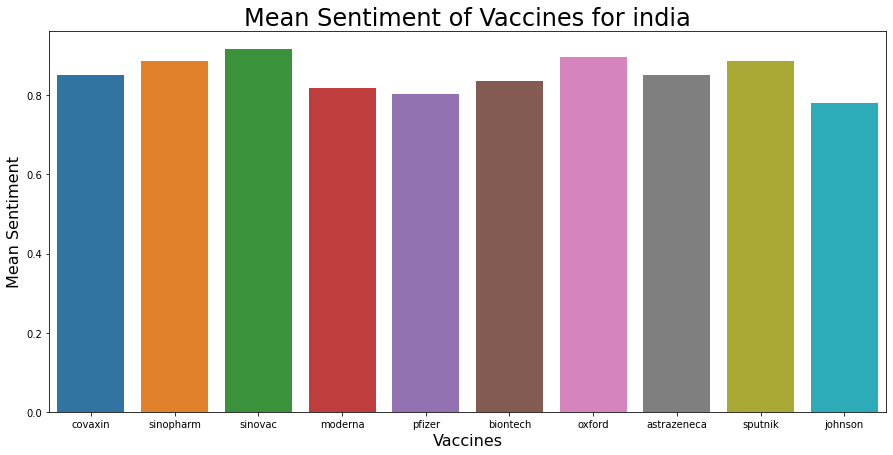

In [65]:
bar_graph_country('india')

In [38]:
country_sentiment=pd.DataFrame()
countries=['india','usa','canada','germany','spain','pakistan','uk','brazil','russia','italy','australia','france','argentina','uae','israel','mexico','japan']
country_sentiment['countries']=countries
senti=list()
vax=vax.dropna()

for country in countries :
    senti.append(vax[vax['user_location'].str.lower().str.contains(country)].Sentiment.mean())
    
country_sentiment['Sentiment']=senti

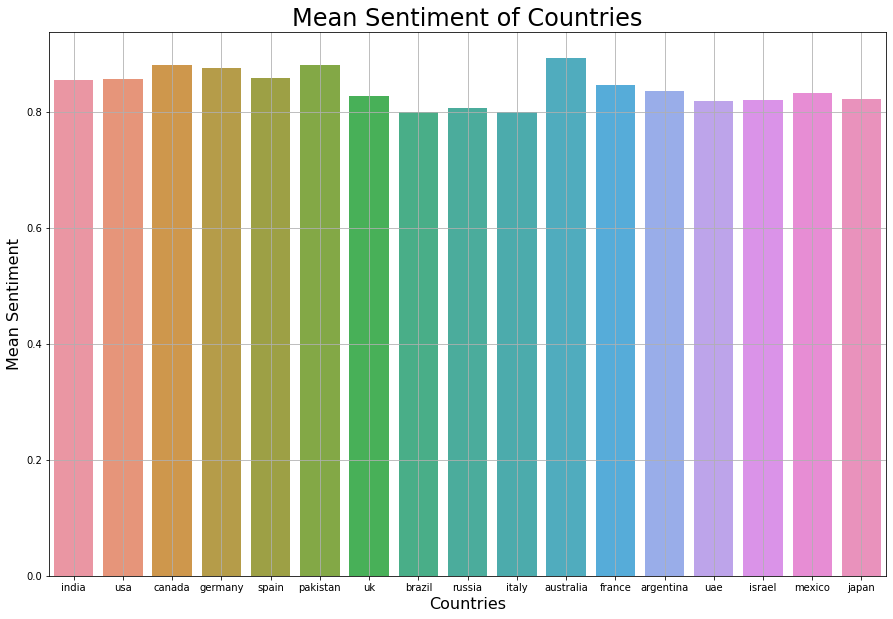

In [39]:
fg,axs=plt.subplots(figsize=(15,10))
sns.barplot(ax=axs,x='countries',y='Sentiment',data=country_sentiment)
axs.set_xlabel("Countries",size=16)
axs.set_ylabel("Mean Sentiment",size=16)
axs.set_title("Mean Sentiment of Countries",size=24)
axs.grid()

In [41]:
def time_variance_country(country) :
    count=vax[vax['user_location'].str.lower().str.contains(country)]

    temp=pd.DataFrame()
    temp['date'] = sorted(count['date'].unique())
    senti=list()

    for date in temp['date']:
        senti.append(count[count['date']==date].Sentiment.mean())

    temp['Sentiment']=senti
    
    fg,axs=plt.subplots(figsize=(15,7))
    sns.lineplot(ax=axs,x='date',y='Sentiment', data= temp)
    axs.set_xlabel("Time",size=16)
    axs.set_ylabel("Sentiment",size=16)
    axs.set_title("Variance of Sentiment wrt Time",size=24)
    axs.grid()

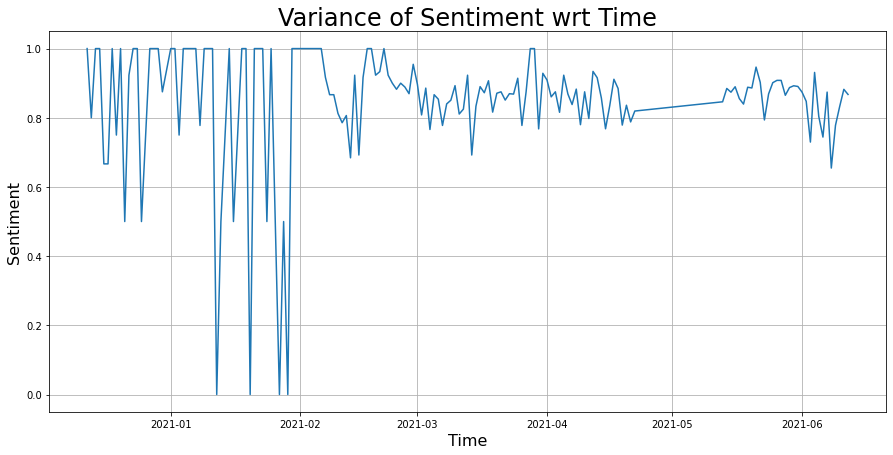

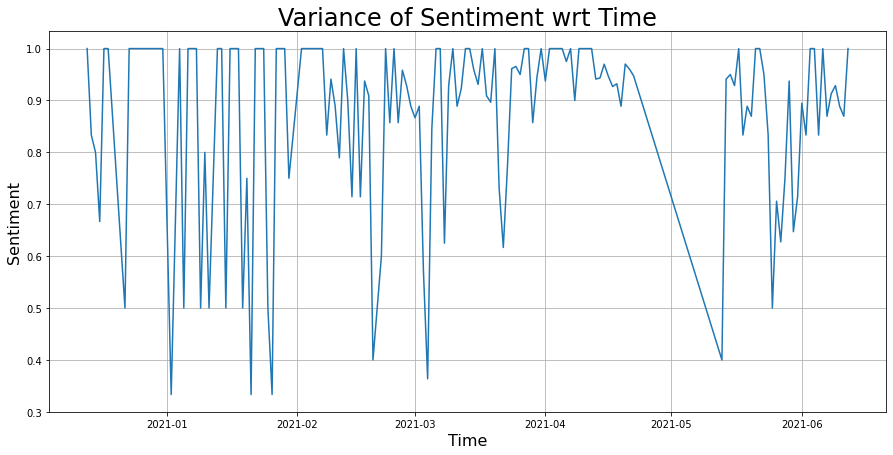

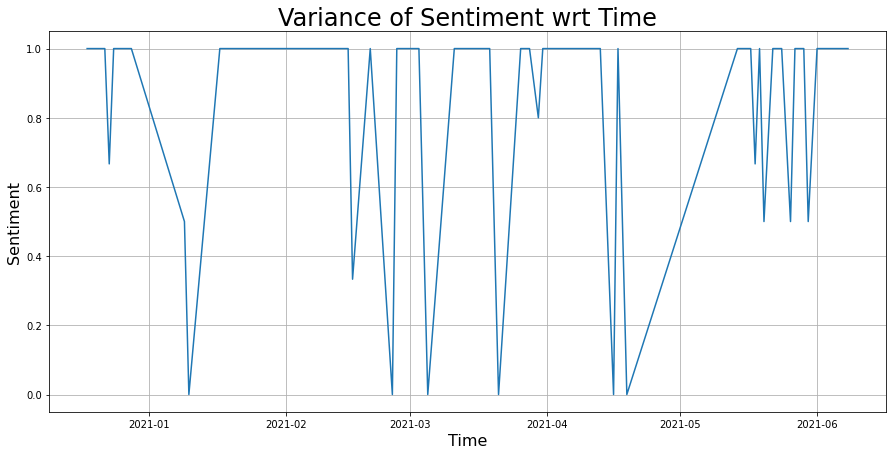

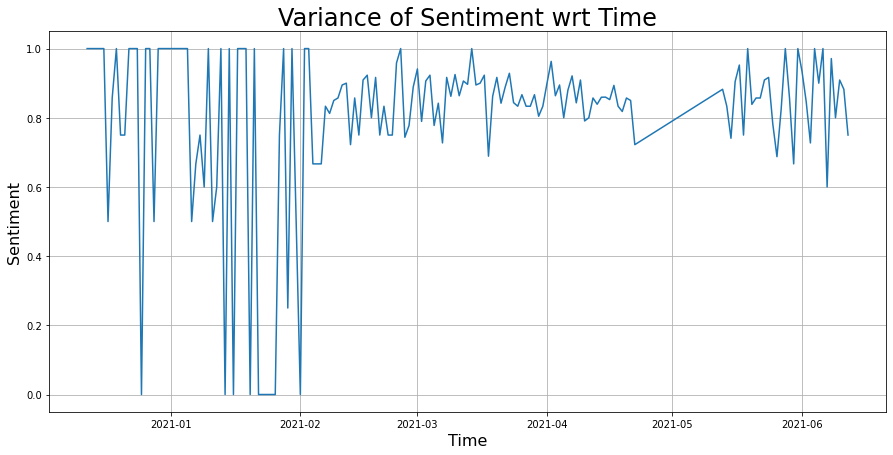

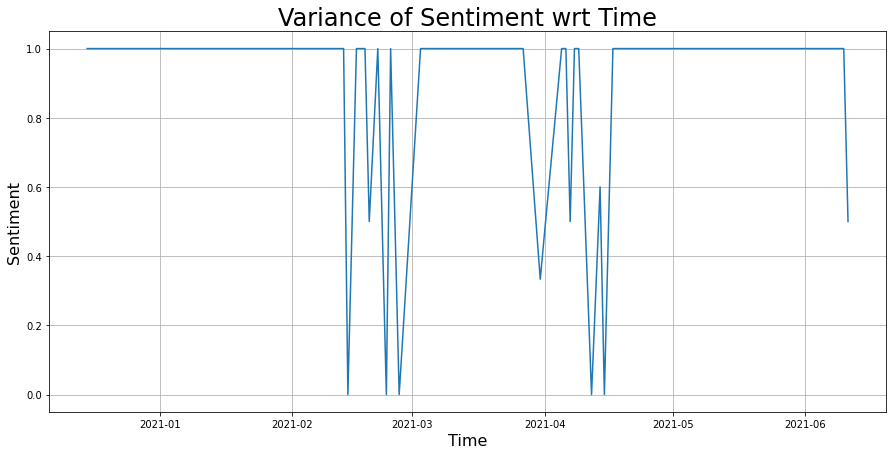

In [42]:
time_variance_country('india')
time_variance_country('canada')
time_variance_country('uae')
time_variance_country('usa')
time_variance_country('spain')


In [43]:
def time_variance_country_vaccine(country, vacc) :
    count=vax[vax['user_location'].str.lower().str.contains(country)]
    count=count[count['text'].str.lower().str.contains(vacc)]

    temp=pd.DataFrame()
    temp['date'] = sorted(count['date'].unique())
    senti=list()

    for date in temp['date']:
        senti.append(count[count['date']==date].Sentiment.mean())

    temp['Sentiment']=senti
    
    fg,axs=plt.subplots(figsize=(15,7))
    sns.lineplot(ax=axs,x='date',y='Sentiment', data= temp)
    axs.set_xlabel("Time",size=16)
    axs.set_ylabel("Sentiment",size=16)
    axs.set_title("Variance of Sentiment wrt Time",size=24)
    axs.grid()

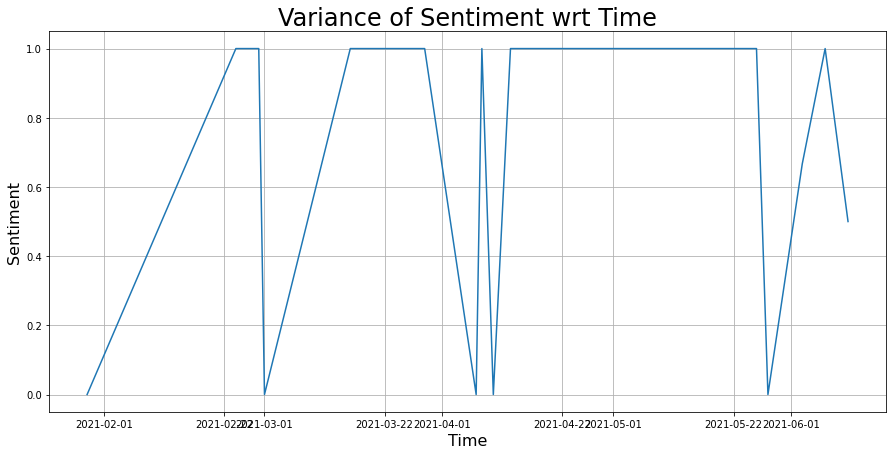

In [63]:
time_variance_country_vaccine('india', 'johnson')